# Connect to database 

In [1]:
import datajoint as dj

DataJoint 0.5.0 (March 8, 2017)
No config file found, using default settings.


In [2]:
dj.config['database.host'] = 'tutorial-db.datajoint.io'
dj.config['database.user'] = 'janelia'

# Create a schema 

In [3]:
schema = dj.schema('janelia_basic', locals())

Please enter DataJoint password: ········
Connecting janelia@tutorial-db.datajoint.io:3306


# Create lookup tables 
Lookup tables contain basic facts that are not specific to an experiment and are fairly persistent.  Their contents are often used in pull-down menus.  Lookup tables are commonly populated from their `contents` method.  In entity-relatationship diagrams they are shown in gray. The decision which tables are `Lookup` and which tables are `Manual` can be somewhat arbitrary.

In [4]:
@schema
class User(dj.Lookup):
    definition = """
    # users in the lab
    username : varchar(20)   # user in the lab
    ---
    first_name  : varchar(20)   # user first name
    last_name   : varchar(20)   # user last name
    """
    contents = [
        ['cajal', 'Santiago', 'Cajal'],
        ['hubel', 'David', 'Hubel'],
        ['wiesel', 'Torsten', 'Wiesel']
    ]

Preview the contents of the table:

In [5]:
User()

username user in the lab,first_name user first name,last_name user last name
cajal,Santiago,Cajal
hubel,David,Hubel
wiesel,Torsten,Wiesel


In [6]:
@schema
class Anesthesia(dj.Lookup):
    definition = """
    # forms of anesthesia
    anesthesia  :  varchar(16)   # short name of anesthesia method
    -----
    anesthesia_protocol  : varchar(20)  # reference to detailed description
    """
    
    contents = [
        ['awake', ''],
        ['fentanyl', ''],
        ['isoflurane', '']
    ]

In [7]:
Anesthesia()

anesthesia short name of anesthesia method,anesthesia_protocol reference to detailed description
awake,
fentanyl,
isoflurane,


In [8]:
@schema
class Rig(dj.Lookup):
    definition = """
    # Experimental rigs (setups) used in the lab
    rig : char(6)  # experimental rig 
    """
    contents = [
        ['J2p1'], ['J2p2']
    ]

In [9]:
Rig()

rig experimental rig
J2p1
J2p2


In [10]:
@schema
class Species(dj.Lookup):
    definition = """
    # species
    species : varchar(16)   # short colloqial name
    ---
    species_formal :  varchar(255)   # binomial nomenclature 
    """
    contents = [
        ['mouse', 'mus musculus'],
        ['human', 'homo sapiens'],
        ['marmoset', 'callithrix jacchus']
    ]

In [11]:
Species()

species short colloqial name,species_formal binomial nomenclature
human,homo sapiens
marmoset,callithrix jacchus
mouse,mus musculus


In [12]:
@schema
class Lens(dj.Lookup):
    definition = """
    # Objective lens
    lens : char(6)  # short name of objective lens
    ---
    na  : decimal(3,2)  # numerical aperture
    wd  : decimal(4,2)  # (mm) working distance
    """
    contents = [
        ['10x', 0.6, 8.0],
        ['16x', 0.8, 3.0],
        ['25x', 1.1, 2.0],
    ]

In [13]:
Lens()

lens short name of objective lens,na numerical aperture,wd (mm) working distance
10x,0.60,8.00
16x,0.80,3.00
25x,1.10,2.00


# Define manual tables
Manual tables are populated during experiment through a variety of interfaces.  Not all manual information is entered by typing.  Automated software can enter it directly into the database.  What makes it manual is that they do not perform any computations inside the pipeline.

In [14]:
@schema
class Animal(dj.Manual):
    definition = """
    # information about animal 
    animal_id : int  # animal id assigned by the lab
    ---
    -> Species
    date_of_birth=null : date  # YYYY-MM-DD optional
    sex='' : enum('M', 'F', '')   # leave empty if unspecified
    """

In [15]:
@schema
class Session(dj.Manual):
    definition = """
    # Experiment Session
    -> Animal
    session  : smallint  # session number for the animal
    --- 
    session_date : date  # YYYY-MM-DD
    -> User
    -> Anesthesia
    -> Rig
    """

In [16]:
@schema 
class Scan(dj.Manual):
    definition = """
    # Two-photon imaging scan
    -> Session 
    scan : smallint  # scan number within the session
    ---
    -> Lens
    laser_wavelength : decimal(5,1)  # um
    laser_power      : decimal(4,1)  # mW    
    """

# Entity Relationship Diagram

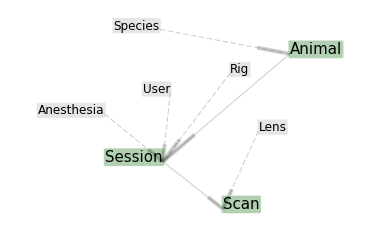

In [17]:
dj.ERD(schema).draw()

# Enter fake data

Add row a dict:

In [18]:
Animal().insert1(dict(animal_id=1010, species='mouse', date_of_birth="2017-04-01", sex="M"))

Add row as a sequence

In [19]:
Animal().insert1([1011, 'mouse', "2017-04-02", "F"])

Add multiple rows at once:

In [20]:
Animal().insert((
    [1012, 'mouse', '2017-04-03', 'F'], 
    [1013, 'mouse', '2017-04-03', 'M'],
    [1014, 'mouse', '2017-04-03', 'M']))

Add Sessions and Scans

In [21]:
Session().insert([
    [1010, 1, '2017-05-15', 'cajal', 'awake', 'J2p1'],
    [1011, 1, '2017-05-16', 'cajal', 'awake', 'J2p1'],
    [1011, 2, '2017-05-17', 'wiesel', 'awake', 'J2p1'],
    [1012, 1, '2017-05-17', 'cajal', 'awake', 'J2p2'],
    [1012, 2, '2017-05-18', 'cajal', 'awake', 'J2p1'],
    [1012, 3, '2017-05-18', 'hubel', 'awake', 'J2p2'],
    [1013, 1, '2017-05-18', 'cajal', 'awake', 'J2p1'],
    [1014, 1, '2017-05-19', 'hubel', 'awake', 'J2p1'],
])


In [23]:
Scan().insert([
    [1010, 1, 1, '10x', '960', '18.5'],
    [1010, 1, 2, '10x', '960', '18.5'],
    [1010, 1, 3, '10x', '960', '40.0'],
    [1011, 1, 1, '16x', '980', '32.0'],
    [1011, 1, 2, '16x', '980', '32.0'],
    [1011, 2, 1, '25x', '960', '8.0'],
    [1011, 2, 2, '25x', '960', '32.0'],
    [1011, 2, 3, '10x', '960', '120.0'],
    [1011, 2, 4, '16x', '920', '80.0'],
    [1011, 2, 5, '16x', '920', '32.0'],
    [1011, 2, 6, '16x', '920', '32.0'],
    [1012, 1, 1, '16x', '920', '32.0'],
    [1012, 1, 2, '16x', '920', '32.0'],
    [1012, 2, 1, '16x', '800', '20.0'],
    [1012, 2, 2, '16x', '800', '36.0'],
    [1012, 2, 3, '16x', '800', '36.0'],
    [1012, 3, 1, '16x', '880', '20.0'],
    [1012, 3, 2, '16x', '800', '36.0'],
    [1012, 3, 3, '25x', '800', '36.0'],
    [1013, 1, 1, '10x', '860', '50.0'],
    [1014, 1, 1, '16x', '1080', '85.5']])

In [26]:
Animal()*Session()*Scan()

animal_id animal id assigned by the lab,session session number for the animal,scan scan number within the session,species short colloqial name,date_of_birth YYYY-MM-DD optional,sex leave empty if unspecified,session_date YYYY-MM-DD,username user in the lab,anesthesia short name of anesthesia method,rig experimental rig,lens short name of objective lens,laser_wavelength um,laser_power mW
1010,1,1,mouse,2017-04-01,M,2017-05-15,cajal,awake,J2p1,10x,960.0,18.5
1010,1,2,mouse,2017-04-01,M,2017-05-15,cajal,awake,J2p1,10x,960.0,18.5
1010,1,3,mouse,2017-04-01,M,2017-05-15,cajal,awake,J2p1,10x,960.0,40.0
1011,1,1,mouse,2017-04-02,F,2017-05-16,cajal,awake,J2p1,16x,980.0,32.0
1011,1,2,mouse,2017-04-02,F,2017-05-16,cajal,awake,J2p1,16x,980.0,32.0
1011,2,1,mouse,2017-04-02,F,2017-05-17,wiesel,awake,J2p1,25x,960.0,8.0
1011,2,2,mouse,2017-04-02,F,2017-05-17,wiesel,awake,J2p1,25x,960.0,32.0
